1 Input Layer -
1 Hidden Layer -
1 Output Layer

In [1]:
import numpy as np
import numpy.random as r
import matplotlib.pyplot as plt

In [2]:
# relu activation function
def relu(x):
    return np.maximum(x,0)

# loss function
def Loss(y_true_vec, y_pred_vec):
    return np.sum((y_true_vec-y_pred_vec)**2)

# softmax function
def softmax(v):
    # takes a vector v as input
    temp = np.exp(v)
    return temp/np.sum(temp)

# heaviside theta function
# for this I will use the built in function np.heaviside(x,0)

# kronecker delta function
def kronecker(x,y):
    if x==y:
        return 1
    else:
        return 0

In [3]:
# forward feeding
def forward_feed(w,a_0,b):
    # a_0 corresponds the input array (input layer)
    # activations at hidden layer
    Z1 = np.matmul(w.T,a_0)+b
    # I am using the ReLU activation function here
    a1_new = relu(Z1)

    # at output layer, I used softmax function
    return softmax(a1_new)

In [4]:
# back_propagate
def back_propagate(w,a_0,b,lr,y_pred_vec,y_true_vec,n_input_nodes,n_hidden_nodes):
      # lr : learning rate
      # gradients
      b_grads = np.zeros((n_hidden_nodes,),float)
      w_grads = np.zeros((n_input_nodes,n_hidden_nodes),float)
      Z1 = np.matmul(w.T,a_0)+b
      theta_Z = np.heaviside(Z1,0.0)
      # calculating gradients w.r.t b (biases)
      for j in range(n_hidden_nodes):
         vec1 = y_pred_vec - y_true_vec
         kronecker_vec = np.array([kronecker(i,j) for i in range(n_hidden_nodes)])
         vec2 = y_pred_vec*kronecker_vec-y_pred_vec*y_pred_vec[j]
         b_grads[j] = 2*theta_Z[j]*np.matmul(vec1,vec2)              
      # calculating gradients w.r.t w (weights)
      for r in range(n_input_nodes):
         for j in range(n_hidden_nodes):
            w_grads[r][j] = a_0[r]*b_grads[j]
      # updating weights and biases
      w_new = w - lr*w_grads
      b_new = b - lr*b_grads
      return w_new, b_new

In [5]:
# batch normalization
def batch_norm(X_train):
    min_arr = np.min(X_train, axis=0)
    max_arr = np.max(X_train, axis=0)
    X_train_norm = (X_train - min_arr) / (max_arr - min_arr)
    return X_train_norm, min_arr, max_arr

In [6]:
# building the neural network
def NN(X_train,y_train,n_input_nodes,n_hidden_nodes,lr,n_epochs):
    # start with batch normalization
    X_train_norm, min_arr, max_arr = batch_norm(X_train)
    N = len(X_train)

    # randomly initializing the weights and biases
    b = r.rand(n_hidden_nodes)
    w = r.rand(n_input_nodes,n_hidden_nodes)
    
    # making a loss array
    loss_arr_epoch=[]

    # loop for iterating over epochs
    for i in range(n_epochs):
        loss_arr=[]
        for j in range(N):
            a_0 = X_train_norm[j]
            y_true_label = y_train[j]
            # forward feeding the data
            y_pred_vec = forward_feed(w,a_0,b)
            # evaluating the loss
            y_true_vec = np.array([kronecker(s,y_true_label) for s in range(n_hidden_nodes)])
            loss_arr.append(Loss(y_true_vec, y_pred_vec))
            # back-propagating the network
            w,b = back_propagate(w,a_0,b,lr,y_pred_vec,y_true_vec,n_input_nodes,n_hidden_nodes)
        loss_arr_epoch.append(np.mean(np.array(loss_arr)))
        if (i+1)%int(n_epochs/10) == 0:
            print(f'{100*(i+1)/n_epochs} % training completed')
    return w,b,min_arr,max_arr,loss_arr_epoch

In [7]:
# making predictions from the learnt parameters
def predict(w,b,min_arr,max_arr,X_test):
    y_pred = []
    # first batch normalise the features
    X_test_norm = (X_test - min_arr) / (max_arr - min_arr)
    # making individual predictions
    for i in range(len(X_test_norm)):
        prob_vector = forward_feed(w,X_test_norm[i],b)      # probability vector
        y_pred.append(np.argmax(prob_vector))
    return np.array(y_pred)

The structure of the neural network is ready. I will next use a toy dataset to demonstrate training.

In [8]:
# toy dataset from scikit-learn database
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()
print(iris.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


In [9]:
data = iris.data
y_true = iris.target
print('Iris dataset details :')
print('---------------------------------------------------------------------------------------------------')
print('Feature names :',iris.feature_names)
print('Target names :',iris.target_names)

# structure of the NN

n_input_nodes = len(data[0])                   # this shall be the dimension of feature space
n_output = len(iris.target_names)
# since I am using the softmax function, no. of output labels must be equal to the number of nodes in hidden layer
n_hidden_nodes = n_output                 # this also corresponds to number of bias terms in the network
print('Number of available data points :',len(data))

print('---------------------------------------------------------------------------------------------------')
print('n(Input layers) :',n_input_nodes)
print('n(Hidden layers) :',n_hidden_nodes)
print('n(Output layers) :',n_output)
print('Number of trainable parameters :',n_input_nodes*n_hidden_nodes+n_hidden_nodes)

Iris dataset details :
---------------------------------------------------------------------------------------------------
Feature names : ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names : ['setosa' 'versicolor' 'virginica']
Number of available data points : 150
---------------------------------------------------------------------------------------------------
n(Input layers) : 4
n(Hidden layers) : 3
n(Output layers) : 3
Number of trainable parameters : 15


In [10]:
# splitting the data into training and testing set
X_train,X_test,y_train,y_test = train_test_split(data,y_true,test_size=0.40,random_state=10)
print('Size of the training set :',len(X_train))
print('Size of the testing set :',len(X_test))

Size of the training set : 90
Size of the testing set : 60


In [11]:
# training the network
n_epochs = 5000            # enter a value atleast greater than 10
learning_rate = 0.1
w,b,min_arr,max_arr,loss_arr_epoch = NN(X_train,y_train,n_input_nodes,n_hidden_nodes,lr=learning_rate,n_epochs=n_epochs)

10.0 % training completed
20.0 % training completed
30.0 % training completed
40.0 % training completed
50.0 % training completed
60.0 % training completed
70.0 % training completed
80.0 % training completed
90.0 % training completed
100.0 % training completed


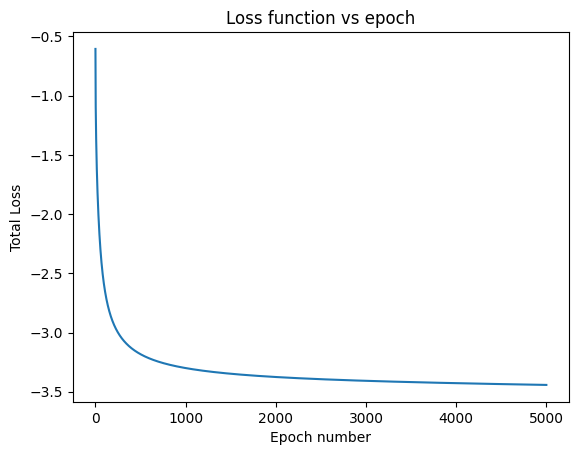

In [12]:
plt.plot(np.arange(n_epochs),np.log(loss_arr_epoch))
plt.title('Loss function vs epoch')
plt.xlabel('Epoch number')
plt.ylabel('Total Loss')
plt.show()

In [13]:
# learnt parameters
print('Weights :\n\n',w,'\n')
print('Biases :\n\n',b)

Weights :

 [[ -2.70245696   6.71314883  -1.47180456]
 [ 11.40628685  -0.75959644  -8.70850888]
 [-10.60682474  -6.4088654   20.20754247]
 [-11.14399951  -2.68614389  16.58485174]] 

Biases :

 [ 10.37741548   8.82917238 -14.74210017]


Evaluating the networks accuracy for testing dataset

In [14]:
y_test_pred = predict(w,b,min_arr,max_arr,X_test)
n_correct_predictions = 0
for i in range(len(y_test_pred)):
    if y_test[i]==y_test_pred[i]:
        n_correct_predictions+=1
print('Total number of test samples :',len(X_test))
print('Total number of correct predictions :',n_correct_predictions)
print('Accuracy Score :',n_correct_predictions/len(y_test_pred))

Total number of test samples : 60
Total number of correct predictions : 58
Accuracy Score : 0.9666666666666667
